In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Online shoe retailer **FLO** wants to divide up its customers into different groups and develop marketing tactics for each group. To do this, the customer behaviors will be identified,
and groups will be created based on clusters in these behaviors.

In the first step, **RFM analysis** will be performed.

# RFM ANALYSİS

* 1. Data Understanding
* 2. Data Preparation
* 3. Calculating RFM Metrics
* 4. Calculating RFM Scores
* 5. Creating & Analysing RFM Segments

***  Variables**
*  master_id: Unique customer number
*  order_channel: Which channel of the shopping platform is used (Android, ios, Desktop, Mobile)
*  last_order_channel: The channel where the most recent purchase was made
*  first_order_date: Date of the customer's first purchase
*  last_order_date: Date of the customer's last purchase
*  last_order_date_online: Date of the customer's last purchase on the online platform
*  last_order_date_offline: Date of the customer's last purchase on the offline platform
*  order_num_total_ever_online: Number of purchases made by the customer on the online platform
*  order_num_total_ever_offline: Number of purchases made by the customer on the offline platform
*  customer_value_total_ever_offline: The total fee paid by the customer for their offline shopping
*  customer_value_total_ever_online: The total fee paid by the customer for their online shopping
*  interested_in_categories_12: List of categories the customer has shopped in the last 12 months

## Data Understanding

In [2]:
import datetime as dt
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df_ = pd.read_csv("../input/flo-data-set/flo_data_20k.csv")
df = df_.copy()

In [6]:
# Data overview
def check_df(dataframe, head=10):
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Variables #####################")
    print(dataframe.columns)
    print("##################### Descriptive Stats #####################")
    print(dataframe.describe().T)
    print("##################### Null Values #####################")
    print(dataframe.isnull().sum())
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Info #####################")
    print(dataframe.info())
    
check_df(df)

##################### Head #####################
                              master_id order_channel last_order_channel  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile   
2  69b69676-1a40-11ea-941b-000d3a38a36f   Android App        Android App   
3  1854e56c-491f-11eb-806e-000d3a38a36f   Android App        Android App   
4  d6ea1074-f1f5-11e9-9346-000d3a38a36f       Desktop            Desktop   
5  e585280e-aae1-11e9-a2fc-000d3a38a36f       Desktop            Offline   
6  c445e4ee-6242-11ea-9d1a-000d3a38a36f   Android App        Android App   
7  3f1b4dc8-8a7d-11ea-8ec0-000d3a38a36f        Mobile            Offline   
8  cfbda69e-5b4f-11ea-aca7-000d3a38a36f   Android App        Android App   
9  1143f032-440d-11ea-8b43-000d3a38a36f        Mobile             Mobile   

  first_order_date last_order_date last_order_date_online  \
0       2020-10-30      2021-02-26             2021-0

## Data Preparation

In [7]:
#Omnichannel means that customers shop from both online and offline platforms.
df["Omnichannel_order_num_total"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["Omnichannel_customer_value_total"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]
#Analysis of variable types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [8]:
# Convert the type of variables that express date to date type.
df.loc[:, df.columns.str.contains("date")] = df.loc[:, df.columns.str.contains("date")].apply(pd.to_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  float64       
 9   customer_value_total_ever_offline  19945 non-null  float64       
 10  customer_value_total_ever_online  

             order_channel  Ratio
Android App           9495 47.606
Mobile                4882 24.477
Ios App               2833 14.204
Desktop               2735 13.713
##########################################


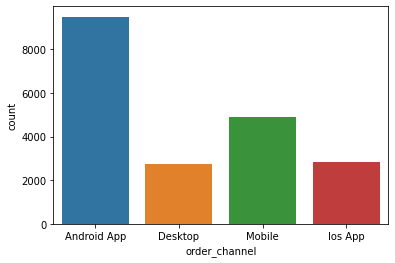

In [9]:
# Variable distribution and visualizations
## Categorical variable
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
#According to the result of the relevant function, we can visually and
#numerically see from which channels customers shop more.     
cat_summary(df, "order_channel", plot=True)

In [ ]:
## Numeric variable
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    print("#"*9)
    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col.upper())
        plt.show(block=True)
# According to the result of the relevant function
# , we can see the total number of purchases and the fee paid by the customers as a result of their purchases.
num_summary(df,"Omnichannel_order_num_total", plot=True)
num_summary(df,"Omnichannel_customer_value_total", plot=True)

Average and sum of total number of orders and paid price for each order channel

In [53]:
df.groupby('order_channel').agg({"master_id": "count",
                                "Omnichannel_order_num_total": ["mean", "sum"],
                                 "Omnichannel_customer_value_total": ["mean", "sum"]})

master_id Omnichannel_order_num_total            \
                  count                        mean       sum   
order_channel                                                   
Android App        9495                       4.819 45752.000   
Desktop            2735                       3.709 10143.000   
Ios App            2833                       4.691 13291.000   
Mobile             4882                       4.031 19680.000   

              Omnichannel_customer_value_total              
                                          mean         sum  
order_channel                                               
Android App                            721.620 6851777.570  
Desktop                                545.474 1491871.580  
Ios App                                753.086 2133493.730  
Mobile                                 578.164 2822597.380

In [11]:
#Sorted values
df.sort_values("Omnichannel_customer_value_total", ascending=False).head(10)

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,Omnichannel_order_num_total,Omnichannel_customer_value_total
11150,5d1c466a-9cfd-11e9-9897-000d3a38a36f,Android App,Desktop,2013-10-11,2021-04-30,2021-04-30,2020-12-24,200.000,2.000,684.970,45220.130,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",202.000,45905.100
7223,cba59206-9dd1-11e9-9897-000d3a38a36f,Android App,Android App,2013-02-21,2021-05-09,2021-05-09,2020-01-25,130.000,1.000,49.990,12232.250,"[AKTIFCOCUK, ERKEK, KADIN, AKTIFSPOR]",131.000,12282.240
8783,a57f4302-b1a8-11e9-89fa-000d3a38a36f,Android App,Offline,2019-08-07,2020-11-04,2020-09-07,2020-11-04,2.000,109.000,10239.460,143.980,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",111.000,10383.440
2619,fdbe8304-a7ab-11e9-a2fc-000d3a38a36f,Android App,Offline,2018-10-18,2020-06-30,2018-10-18,2020-06-30,1.000,87.000,8432.250,139.980,[ERKEK],88.000,8572.230
6322,329968c6-a0e2-11e9-a2fc-000d3a38a36f,Ios App,Ios App,2019-02-14,2021-04-05,2021-04-05,2020-02-17,2.000,81.000,3997.550,242.810,[ERKEK],83.000,4240.360
7613,73fd19aa-9e37-11e9-9897-000d3a38a36f,Ios App,Offline,2014-01-14,2021-05-18,2021-01-30,2021-05-18,81.000,1.000,1263.760,32654.340,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",82.000,33918.100
9347,44d032ee-a0d4-11e9-a2fc-000d3a38a36f,Mobile,Mobile,2019-02-11,2021-02-11,2021-02-11,2020-12-24,3.000,74.000,4640.770,543.280,"[KADIN, AKTIFSPOR]",77.000,5184.050
10954,b27e241a-a901-11e9-a2fc-000d3a38a36f,Mobile,Mobile,2015-09-12,2021-04-01,2021-04-01,2019-10-08,72.000,3.000,292.930,5004.950,"[AKTIFCOCUK, ERKEK, KADIN, AKTIFSPOR]",75.000,5297.880
8068,d696c654-2633-11ea-8e1c-000d3a38a36f,Ios App,Ios App,2017-05-10,2021-04-13,2021-04-13,2019-08-15,69.000,1.000,82.480,16836.090,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",70.000,16918.570
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,Desktop,Desktop,2020-02-16,2021-04-30,2021-04-30,2020-12-18,66.000,4.000,843.680,17599.890,"[ERKEK, KADIN, AKTIFSPOR]",70.000,18443.570


In [12]:
df.sort_values("Omnichannel_order_num_total", ascending=False).head(10)

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,Omnichannel_order_num_total,Omnichannel_customer_value_total
11150,5d1c466a-9cfd-11e9-9897-000d3a38a36f,Android App,Desktop,2013-10-11,2021-04-30,2021-04-30,2020-12-24,200.000,2.000,684.970,45220.130,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",202.000,45905.100
7223,cba59206-9dd1-11e9-9897-000d3a38a36f,Android App,Android App,2013-02-21,2021-05-09,2021-05-09,2020-01-25,130.000,1.000,49.990,12232.250,"[AKTIFCOCUK, ERKEK, KADIN, AKTIFSPOR]",131.000,12282.240
8783,a57f4302-b1a8-11e9-89fa-000d3a38a36f,Android App,Offline,2019-08-07,2020-11-04,2020-09-07,2020-11-04,2.000,109.000,10239.460,143.980,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",111.000,10383.440
2619,fdbe8304-a7ab-11e9-a2fc-000d3a38a36f,Android App,Offline,2018-10-18,2020-06-30,2018-10-18,2020-06-30,1.000,87.000,8432.250,139.980,[ERKEK],88.000,8572.230
6322,329968c6-a0e2-11e9-a2fc-000d3a38a36f,Ios App,Ios App,2019-02-14,2021-04-05,2021-04-05,2020-02-17,2.000,81.000,3997.550,242.810,[ERKEK],83.000,4240.360
7613,73fd19aa-9e37-11e9-9897-000d3a38a36f,Ios App,Offline,2014-01-14,2021-05-18,2021-01-30,2021-05-18,81.000,1.000,1263.760,32654.340,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",82.000,33918.100
9347,44d032ee-a0d4-11e9-a2fc-000d3a38a36f,Mobile,Mobile,2019-02-11,2021-02-11,2021-02-11,2020-12-24,3.000,74.000,4640.770,543.280,"[KADIN, AKTIFSPOR]",77.000,5184.050
10954,b27e241a-a901-11e9-a2fc-000d3a38a36f,Mobile,Mobile,2015-09-12,2021-04-01,2021-04-01,2019-10-08,72.000,3.000,292.930,5004.950,"[AKTIFCOCUK, ERKEK, KADIN, AKTIFSPOR]",75.000,5297.880
8068,d696c654-2633-11ea-8e1c-000d3a38a36f,Ios App,Ios App,2017-05-10,2021-04-13,2021-04-13,2019-08-15,69.000,1.000,82.480,16836.090,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",70.000,16918.570
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,Desktop,Desktop,2020-02-16,2021-04-30,2021-04-30,2020-12-18,66.000,4.000,843.680,17599.890,"[ERKEK, KADIN, AKTIFSPOR]",70.000,18443.570


In [ ]:
# we turn everything we do into function
def data_prep(dataframe, cat_variables=[], num_variables =[], sort_values =[] , date_str = "date", head = 10, plot=False):
    
    dataframe["Omnichannel_order_num_total"] = dataframe["order_num_total_ever_online"] + dataframe["order_num_total_ever_offline"]
    dataframe["Omnichannel_customer_value_total"] = dataframe["customer_value_total_ever_offline"] + dataframe["customer_value_total_ever_online"]
    
    check_df(dataframe, head)
    dataframe.loc[:, dataframe.columns.str.contains(date_str)] = dataframe.loc[:, dataframe.columns.str.contains(date_str)].apply(pd.to_datetime)

    for col in cat_variables:
        cat_summary(dataframe, col, plot)

    for col in num_variables:
        num_summary(dataframe, col, plot)

    for col in sort_values:
        print("*"*9)
        print(f"#### sorted by {col} ####")
        print(dataframe.sort_values(col, ascending=False).head(head))

    return dataframe

# Calculating RFM Metrics

In [14]:
# We set the analysis time to two day after the last order date
df["last_order_date"].max()
today_date = dt.datetime(2021, 6, 1)

# We do grouping for each customer to get the RFM values
rfm = df.groupby('master_id').agg({'last_order_date': lambda last_order_date: (today_date - last_order_date).dt.days,#ilgili müşterinin son satın alma tarihini bugünden çıkar gün cinsinden ver
                                     'Omnichannel_order_num_total': lambda Omnichannel_order_num_total: Omnichannel_order_num_total,
                                     'Omnichannel_customer_value_total': lambda Omnichannel_customer_value_total: Omnichannel_customer_value_total})
rfm.head()
rfm.columns = ['recency', 'frequency', 'monetary']

rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,19945.000,134.458,103.281,2.000,43.000,111.000,202.000,367.000
frequency,19945.000,5.025,4.743,2.000,3.000,4.000,6.000,202.000
monetary,19945.000,751.244,895.402,44.980,339.980,545.270,897.780,45905.100


# Calculating RFM Scores

In [15]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm["RF_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))

# Creating & Analysing RFM Segments

In [16]:
# Customers are segmented based on standardized values.
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

rfm['segment'] = rfm['RF_SCORE'].replace(seg_map, regex=True)

rfm_final = rfm.merge(df, on="master_id", how="left")

In [54]:
# Mean and count values of RFM values of segmented customers
rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "count"])

recency       frequency       monetary      
                       mean count      mean count     mean count
segment                                                         
about_to_sleep      114.032  1643     2.407  1643  361.649  1643
at_risk             242.329  3152     4.470  3152  648.325  3152
cant_loose          235.159  1194    10.717  1194 1481.652  1194
champions            17.142  1920     8.965  1920 1410.709  1920
hibernating         247.426  3589     2.391  3589  362.583  3589
loyal_customers      82.558  3375     8.356  3375 1216.257  3375
need_attention      113.037   806     3.739   806  553.437   806
new_customers        17.976   673     2.000   673  344.049   673
potential_loyalists  36.870  2925     3.311  2925  533.741  2925
promising            58.695   668     2.000   668  334.153   668

Scenario 1:
FLO incorporates a new brand of women's shoes into its structure. The product prices of the brand it includes are above the general customer preferences. Therefore, it is desirable to contact the customers in the profile that will be interested in the promotion of the brand and the sales of the product. Customers to be contacted privately from loyal customers (champions, loyal_customers) and people who shop from the female category.

In [55]:
# target_segments_customer_ids = rfm[rfm["segment"].isin(["champions", "loyal_customers"])]["customer_id"]
# cust_ids = \
# df[(df["master_id"].isin(target_segments_customer_ids)) & (df["interested_in_categories_12"].str.contains("KADIN"))]["master_id"]

In [17]:
new_df = pd.DataFrame()
new_df["loyals_id"] = rfm_final[(rfm_final["interested_in_categories_12"].str.contains("KADIN")) &
          ((rfm_final["segment"] == "champions") | (rfm_final["segment"] == "loyal_customers"))]["master_id"]

In [33]:
new_df.head(5)

,loyals_id
3,000c1fe2-a8b7-11ea-8479-000d3a38a36f
18,003903e0-abce-11e9-a2fc-000d3a38a36f
22,004bec18-9f7a-11e9-a2fc-000d3a38a36f
25,00534fe4-a6b4-11e9-a2fc-000d3a38a36f
49,009293fe-1f3e-11ea-87bf-000d3a38a36f


Scenario 2:
Up to 40% discount is planned for Men's and Children's products.Customers who are loyal in the past and have not shopped for a long time will be the ones we are going to focus on.Those who are asleep, and new customers are specifically targeted.

In [31]:
new_df_2 = pd.DataFrame()
new_df_2["customers_discounted"] = rfm_final[rfm_final["interested_in_categories_12"].str.contains('ERKEK|COCUK') & ((rfm_final["segment"] == "hibernating") | (rfm_final["segment"] == "cant_loose") |
                                                (rfm_final["segment"] == "new_customers"))]["master_id"]

In [57]:
new_df_2.head(5)

,customers_discounted
1,00034aaa-a838-11e9-a2fc-000d3a38a36f
11,00263f1a-210a-11ea-b50a-000d3a38a36f
16,0033f078-7359-11ea-92d0-000d3a38a36f
34,006bb20e-a9a8-11e9-a2fc-000d3a38a36f
40,007cdfe4-1f54-11ea-87bf-000d3a38a36f


In [ ]:
default_time = df["last_order_date"].max() + dt.timedelta(days=2)
def RFM_analysis(dataframe, analysis_time = default_time):
    rfm = dataframe.groupby('master_id').agg({'last_order_date': lambda last_order_date: (analysis_time - last_order_date).dt.days,
                                     'Omnichannel_order_num_total': lambda Omnichannel_order_num_total: Omnichannel_order_num_total,
                                     'Omnichannel_customer_value_total': lambda Omnichannel_customer_value_total: Omnichannel_customer_value_total})
    rfm.head()
    rfm.columns = ['recency', 'frequency', 'monetary']
    rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
    rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
    rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])
    rfm["RF_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))
    seg_map = {
        r'[1-2][1-2]': 'hibernating',
        r'[1-2][3-4]': 'at_risk',
        r'[1-2]5': 'cant_loose',
        r'3[1-2]': 'about_to_sleep',
        r'33': 'need_attention',
        r'[3-4][4-5]': 'loyal_customers',
        r'41': 'promising',
        r'51': 'new_customers',
        r'[4-5][2-3]': 'potential_loyalists',
        r'5[4-5]': 'champions'
    }
    rfm['segment'] = rfm['RF_SCORE'].replace(seg_map, regex=True)
    rfm_final = rfm.merge(dataframe, on="master_id", how="left")
    return rfm_final[["recency", "frequency", "monetary", "recency_score",
                     "frequency_score", "monetary_score", "RF_SCORE",
                     "segment"]]

# CLTV Prediction

* 1. Data Understanding
* 2. Data Preparation
* 3. BG-NBD Model
* 4. Gamma-Gamma Model
* 5. CLTV Prediction
* 6. Segmentation of Customers by CLTV

FLO wants to set a roadmap for its sales and marketing activities. In order for the company to make a medium-long-term plan,it is necessary to estimate the potential value that the existing customers will provide to the future company.

In [36]:
!pip install lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.7 MB/s eta 0:00:00


In [69]:
import datetime as dt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

In [70]:
df_ = pd.read_csv("../input/flo-data-set/flo_data_20k.csv")
df = df_.copy()

In [39]:
check_df(df)

##################### Head #####################
                              master_id order_channel last_order_channel  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile   
2  69b69676-1a40-11ea-941b-000d3a38a36f   Android App        Android App   
3  1854e56c-491f-11eb-806e-000d3a38a36f   Android App        Android App   
4  d6ea1074-f1f5-11e9-9346-000d3a38a36f       Desktop            Desktop   
5  e585280e-aae1-11e9-a2fc-000d3a38a36f       Desktop            Offline   
6  c445e4ee-6242-11ea-9d1a-000d3a38a36f   Android App        Android App   
7  3f1b4dc8-8a7d-11ea-8ec0-000d3a38a36f        Mobile            Offline   
8  cfbda69e-5b4f-11ea-aca7-000d3a38a36f   Android App        Android App   
9  1143f032-440d-11ea-8b43-000d3a38a36f        Mobile             Mobile   

  first_order_date last_order_date last_order_date_online  \
0       2020-10-30      2021-02-26             2021-0

In [72]:
df.describe([0,0.25,0.5,0.75,0.8,0.9,0.95,0.98,0.99]).T

,count,mean,std,min,0%,25%,50%,75%,80%,90%,95%,98%,99%,max
order_num_total_ever_online,19945.000,3.111,4.226,1.000,1.000,1.000,2.000,4.000,4.000,7.000,10.000,15.000,20.000,200.000
order_num_total_ever_offline,19945.000,1.914,2.063,1.000,1.000,1.000,1.000,2.000,3.000,4.000,4.000,6.000,7.000,109.000
customer_value_total_ever_offline,19945.000,253.923,301.533,10.000,10.000,99.990,179.980,319.970,365.058,519.950,694.222,959.980,1219.947,18119.140
customer_value_total_ever_online,19945.000,497.322,832.602,12.990,12.990,149.980,286.460,578.440,690.868,1082.036,1556.726,2370.105,3143.810,45220.130


Standardization was done when calculating the RFM score in the RFM analysis. Since CLTV estimation is a different study and there is no such standardization, we may need to perform an outlier analysis and remove the outliers from the data set.

Since the 25% quarterly and minimum values of the number of online and offline orders are the same, suppressing the lower limits for these variables will not change much. It is seen that the outlier values are much higher at the upper limits. We choose %99 as upper limit as it can be seen that the main difference starts from that point

## Data Preparation

In [73]:
# Outlier Detection
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    up_limit = round(up_limit)
    low_limit = round(low_limit)
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable, low_limit=False):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    if low_limit:
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [74]:
for col in df[["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline",
               "customer_value_total_ever_online"]]:
    replace_with_thresholds(df, col)

In [75]:
#Omnichannel means that customers shop from both online and offline platforms.
df["Omnichannel_order_num_total"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["Omnichannel_customer_value_total"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

In [76]:
# Convert the type of variables that express date to date type.
df.loc[:, df.columns.str.contains("date")] = df.loc[:, df.columns.str.contains("date")].apply(pd.to_datetime)

In [77]:
# Date of analysis
df["last_order_date"].max()
today_date = dt.datetime(2021, 6, 1)

# Preparing CLTV dataframe
cltv_df = pd.DataFrame()
cltv_df["customer_id"] = df["master_id"]
cltv_df["recency_cltv_weekly"] = (df["last_order_date"] - df["first_order_date"]).dt.days
cltv_df['T_weekly'] = (today_date - df["first_order_date"]).dt.days
cltv_df['frequency'] = df["Omnichannel_order_num_total"]
cltv_df["monetary_cltv_avg"] = df["Omnichannel_customer_value_total"] / cltv_df["frequency"]

cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
cltv_df["recency_cltv_weekly"] = cltv_df["recency_cltv_weekly"] / 7
cltv_df["T_weekly"] = cltv_df["T_weekly"] / 7

## BG-NBD Model

In [78]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency_cltv_weekly'],
        cltv_df['T_weekly'])

#Estimate expected purchases from customers within 3 months
cltv_df["exp_sales_3_month"] = bgf.conditional_expected_number_of_purchases_up_to_time(4 * 3,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency_cltv_weekly'],
                                                        cltv_df['T_weekly'])

#Estimate expected purchases from customers within 6 months
cltv_df["exp_sales_6_month"] = bgf.conditional_expected_number_of_purchases_up_to_time(4 * 6,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency_cltv_weekly'],
                                                        cltv_df['T_weekly'])

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

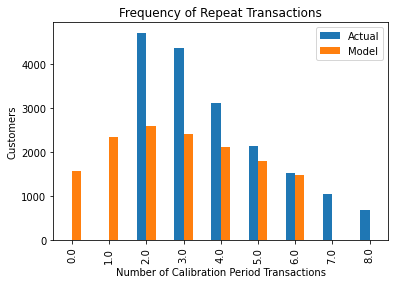

In [79]:
# Visual
plot_period_transactions(bgf)

## Gamma-Gamma Model

In [80]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])

cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary_cltv_avg'])

cltv_df.index = cltv_df["customer_id"]
cltv_df.drop("customer_id", inplace=True, axis=1)

## CLTV Prediction

In [81]:
cltv_df["cltv"] = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency_cltv_weekly'],
                                   cltv_df['T_weekly'],
                                   cltv_df['monetary_cltv_avg'],
                                   time=6, # 6 month
                                   freq="W",
                                   discount_rate=0.01)

cltv_df.sort_values(by="cltv", ascending=False).head(20)

,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
customer_id,,,,,,,,
47a642fe-975b-11eb-8c2a-000d3a38a36f,2.857,7.857,4.000,1401.800,1.094,2.189,1449.060,3327.777
7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.143,13.143,11.000,758.085,1.970,3.940,767.361,3172.394
f59053e2-a503-11e9-a2fc-000d3a38a36f,51.714,101.000,7.000,1106.467,0.722,1.444,1127.612,1708.982
625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.286,74.571,16.000,501.874,1.565,3.131,506.167,1662.613
a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.714,67.286,52.000,166.225,4.656,9.312,166.712,1628.887
9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.429,34.429,8.000,601.226,1.265,2.531,611.493,1623.813
851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.286,9.429,2.000,862.690,0.794,1.588,923.680,1538.856
53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.714,13.000,17.000,259.865,2.781,5.561,262.073,1529.228
55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.571,58.714,31.000,228.530,3.084,6.168,229.607,1485.819


## Segmentation of Customers by CLTV

In [82]:
cltv_df["segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])

recency_cltv_weekly                                  T_weekly          \
                        min     max count    mean        sum      min     max   
segment                                                                         
D                     0.000 432.571  4987 139.000 693193.857    3.571 436.286   
C                     0.000 433.000  4986  92.630 461850.857    5.143 434.714   
B                     0.000 415.571  4986  81.988 408794.000    1.143 423.571   
A                     0.000 433.429  4986  67.427 336191.714    0.714 437.143   

                                 frequency                               \
        count    mean        sum       min    max count  mean       sum   
segment                                                                   
D        4987 162.183 808807.714     2.000 18.000  4987 3.769 18795.000   
C        4986 112.818 562512.143     2.000 32.000  4986 4.405 21962.000   
B        4986 100.327 500228.000     2.000 50.000  4986 5.093 25392.000   
A        4986  82.550 411592.857     2.000 57.000  4986 6.647 33140.000   

        monetary_cltv_avg                                     \
                      min      max count    mean         sum   
segment                                                        
D                  22.490  284.985  4987  93.152  464547.046   
C                  34.316  342.840  4986 125.789  627181.647   
B                  50.043  539.985  4986 160.637  800933.959   
A                  64.364 1401.800  4986 228.831 1140952.075   

        exp_sales_3_month                            exp_sales_6_month        \
                      min   max count  mean      sum               min   max   
segment                                                                        
D                   0.149 1.050  4987 0.409 2039.164             0.299 2.100   
C                   0.162 1.568  4986 0.525 2619.885             0.324 3.137   
B                   0.177 1.782  4986 0.601 2997.110             0.354 3.564   
A                   0.212 4.656  4986 0.773 3854.313             0.424 9.312   

                             exp_average_value                         \
        count  mean      sum               min      max count    mean   
segment                                                                 
D        4987 0.818 4078.328            25.083  306.591  4987  98.691   
C        4986 1.051 5239.769            34.789  368.390  4986 132.251   
B        4986 1.202 5994.219            50.597  578.975  4986 168.001   
A        4986 1.546 7708.626            64.983 1449.060  4986 238.024   

                       cltv                                     
                sum     min      max count    mean         sum  
segment                                                         
D        492172.441  12.108  112.245  4987  80.340  400657.955  
C        659401.453 112.248  165.469  4986 138.312  689621.178  
B        837650.882 165.469  240.058  4986 199.533  994870.784  
A       1186787.639 240.085 3327.777  4986 362.316 1806505.089

In [84]:
# Could there be less segments
cltv_df.groupby("segment").agg({"exp_average_value": "mean",
                                "cltv": "mean",
                               "exp_sales_6_month" : "mean",
                               "frequency": "mean",
                               "monetary_cltv_avg": "mean",
                               "T_weekly": "mean",
                                "recency_cltv_weekly": "mean"})

,exp_average_value,cltv,exp_sales_6_month,frequency,monetary_cltv_avg,T_weekly,recency_cltv_weekly
segment,,,,,,,
D,98.691,80.340,0.818,3.769,93.152,162.183,139.000
C,132.251,138.312,1.051,4.405,125.789,112.818,92.630
B,168.001,199.533,1.202,5.093,160.637,100.327,81.988
A,238.024,362.316,1.546,6.647,228.831,82.550,67.427


In [83]:
default_time = df["last_order_date"].max() + dt.timedelta(days=2)
def CLTV_Prediction(dataframe, analysis_time = default_time, projection_time = 6):
    cltv_df = pd.DataFrame()
    cltv_df["customer_id"] = dataframe["master_id"]
    cltv_df["recency_cltv_weekly"] = (dataframe["last_order_date"] - dataframe["first_order_date"]).dt.days
    cltv_df['T_weekly'] = (today_date - dataframe["first_order_date"]).dt.days
    cltv_df['frequency'] = dataframe["Omnichannel_order_num_total"]
    cltv_df["monetary_cltv_avg"] = dataframe["Omnichannel_customer_value_total"] / cltv_df["frequency"]

    cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
    cltv_df["recency_cltv_weekly"] = cltv_df["recency_cltv_weekly"] / 7
    cltv_df["T_weekly"] = cltv_df["T_weekly"] / 7
    
    bgf = BetaGeoFitter(penalizer_coef=0.001)

    bgf.fit(cltv_df['frequency'],
            cltv_df['recency_cltv_weekly'],
            cltv_df['T_weekly'])

    #Estimate expected purchases from customers within 3 months
    cltv_df["exp_sales_3_month"] = bgf.conditional_expected_number_of_purchases_up_to_time(4 * 3,
                                                            cltv_df['frequency'],
                                                            cltv_df['recency_cltv_weekly'],
                                                            cltv_df['T_weekly'])

    #Estimate expected purchases from customers within 6 months
    cltv_df["exp_sales_6_month"] = bgf.conditional_expected_number_of_purchases_up_to_time(4 * 6,
                                                            cltv_df['frequency'],
                                                            cltv_df['recency_cltv_weekly'],
                                                            cltv_df['T_weekly'])
    ggf = GammaGammaFitter(penalizer_coef=0.01)

    ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])

    cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                                 cltv_df['monetary_cltv_avg'])
    cltv_df.index = cltv_df["customer_id"]
    cltv_df.drop("customer_id", inplace=True, axis=1)
    
    cltv_df["cltv"] = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency_cltv_weekly'],
                                   cltv_df['T_weekly'],
                                   cltv_df['monetary_cltv_avg'],
                                   time=projection_time, # 6 month
                                   freq="W",
                                   discount_rate=0.01)

    print(cltv_df.sort_values(by="cltv", ascending=False).head(20))
    cltv_df["segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])
    print(cltv_df.groupby("segment").agg({"count", "mean", "sum", "min", "max"}))
    return cltv_df